# Supplementary figure 1
___

In [2]:
library(reshape2)
library(dplyr)

library(ggplot2)
# library(cowplot)

In [3]:
parent <- '/prj/Florian_Leuschner_spatial/analysis/Nanopore/' # change this path!
config <- yaml::yaml.load_file(file.path(parent, 'ScNaST', 'workflow', 'config.yaml', fsep=.Platform$file.sep))

local <- getwd() # you might have to adjust this path to make the local files visible

Number of the Nanopore reads identified by ScNapBar at each processing step (details).
---


In [4]:
# prepare data for plotting
df <- purrr::map2(config$samples, names(config$samples), function(.x, .y) {
    log <- file.path(dirname(.x), 'real.log', fsep=.Platform$file.sep)
    label <- file.path(dirname(.x), 'real.label', fsep=.Platform$file.sep)
    # total reads
    data <- dirname(dirname(.x))
    name <- paste(unlist(strsplit(basename(.x), '.', fixed=T))[1], 'fastq.gz', sep='.')
    total <- system(paste0("awk '{s++}END{print s/4}' ", file.path(data, 'data', name, fsep=.Platform$file.sep)), intern=TRUE)
    # assigned barcodes
    assigned <- system(paste0('wc -l ', label), intern=TRUE)
    # scNapBar log
    x <- read.table(log, sep='\t')
    x <- rbind(c('Total reads', total), x)
    x <- rbind(x, c('Assigned to barcode', unlist(strsplit(assigned, ' '))[1]))
    x[,2] <- as.integer(x[,2])
    x <- mutate(x, Assigned=V2/lag(V2)*100)
    # x <- x[-1,]
    # add sample name
    x$Sample <- toupper(substr(.y, nchar(.y), nchar(.y)))
    x
})
df <- do.call("rbind", df)
df$Sample <-  factor(df$Sample, levels=rev(c('A', 'B', 'C', 'D')))
df$Steps <- factor(df[,1], levels=rev(c('Total reads', 'Aligned to genome', 'Aligned to adapter', 'Aligned to barcode', 'Assigned to barcode')))


x <- na.omit(df)
x <- droplevels(x)
f1 <- ggplot(x, aes(x=Sample, y=Assigned, fill=Steps)) + 
    geom_bar(stat="identity", position=position_dodge()) +
    scale_fill_grey(start=0.8, end=0.2) +
    coord_flip() + 
    labs(x="", y="% Assignment per sample") + 
    geom_text(aes(label=V2), position=position_dodge(width=0.9), hjust=1, color = case_when(
      x$Steps == 'Aligned to genome' ~ "white",
      x$Steps != 'Aligned to genome' ~ "black"
    )) +
    guides(fill = guide_legend(reverse=T,nrow=2)) + 
    theme_minimal() +
    theme(legend.title = element_blank(),
          legend.text=element_text(size=15),
          legend.position = "top",
          panel.grid.major.y = element_blank(),
          axis.text = element_text(size = 18),
          axis.title.x = element_text(size = 18))



Reads or alignment at each step (ScNaST)
---

In [5]:
data <- read.table(file.path(local, 'assignment.txt', fsep=.Platform$file.sep))
data$V1 <- factor(data$V1, levels=rev(c('A', 'B', 'C', 'D')))

f2 <- data %>% melt(id.vars=c('V2', 'V1')) %>% na.omit() %>%
    ggplot(aes(y=V1, x=value, fill=V2)) +
    geom_boxplot(outlier.size=1) +
    labs(x="Reads or alignments per barcode (x1000)", y="") + 
    scale_x_continuous(labels=function(x)x/1000) + 
    scale_fill_grey(start=1, end=.4) +
    guides(fill = guide_legend(reverse=T, nrow=1)) + 
    theme_minimal() +
    theme(legend.title = element_blank(),
          legend.text=element_text(size=15),
          legend.position = "top",
          panel.grid.major.y = element_blank(),
          axis.text = element_text(size = 18),
          axis.title.x = element_text(size = 18))

In [11]:
# combine 2 figures into top panel
p <- ggpubr::ggarrange(f1, f2, 
          labels = c("A", "B"),
          ncol = 2, nrow = 1, font.label = list(size = 20))
filen <- file.path(parent, 'ScNaST', 'paper', 'figures', 'S1', fsep=.Platform$file.sep)
filen <- file.path(filen, 'panel1.pdf')
ggsave(filen, width=24, height=8, dpi=1200)

In [12]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /beegfs/biosw/R/4.1.1_deb10/lib/R/lib/libRblas.so
LAPACK: /beegfs/biosw/R/4.1.1_deb10/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.5  dplyr_1.0.7    reshape2_1.4.4

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7       ggpubr_0.4.0     pillar_1.6.5     compiler_4.1.1  
 [5] plyr_1.8.6       base64enc_0.1-3  tools_4.1.1      digest_0.6.29   
 [9] uuid_1.0-3  

Illumina *vs* Nanopore (matching barcodes)
---

Python!

In [12]:
import os

import scanpy as sc

import anndata

import numpy as np
import pandas as pd

import scipy.stats as stats

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white', frameon=False)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
parent = '/prj/Florian_Leuschner_spatial/analysis/Nanopore/' # change this path!

# Illumina and Nanopore results 
# use local objects, we'll copy them to the repository in due time/provide them as supplement

illumina = sc.read_h5ad('/prj/Florian_Leuschner_spatial/analysis/Illumina/data/anatomical_regions_and_cell_props_bbknn.h5ad')
illumina
nanopore = sc.read_h5ad('/prj/Florian_Leuschner_spatial/analysis/Nanopore/Nanopore/data/anatomical_regions_and_cell_props_scnast.h5ad')
nanopore

AnnData object with n_obs × n_vars = 7708 × 8160
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'pct_mt', 'library_id', 'anatomical_region'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-A', 'n_cells-B', 'n_cells-C', 'n_cells-D', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'anatomical_region_colors', 'dendrogram_anatomical_region', 'leiden', 'library_id_colors', 'neighbors', 'pca', 'ranked_anatomical_region', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution', 'spatial'
    varm: 'PCs'
    layers: 'X_explained', 'counts'
    obsp: 'connectivities', 'distances'

AnnData object with n_obs × n_vars = 7616 × 12590
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'library_id', 'anatomical_region', 'nanopore_only', 'C_scANVI'
    var: 'feature_types', 'genome', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code', 'n_cells-A', 'n_cells-B', 'n_cells-C', 'n_cells-D'
    uns: 'C_scANVI_colors', 'anatomical_region_colors', 'hvg', 'library_id_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'deconvolution', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
idx = illumina.obs.reindex(nanopore.obs.index).dropna().index

illumina = illumina[illumina.obs_names.isin(idx), :]
illumina_obs = illumina.obs[['n_counts', 'n_genes', 'pct_mt']].copy()
illumina_obs.rename(columns={'n_counts': 'Illumina counts (genes)', 'n_genes': 'Illumina genes', 'pct_mt': 'Illumina MT pct'}, inplace=True)

nanopore = nanopore[nanopore.obs_names.isin(idx), :]
nanopore_obs = nanopore.obs[['n_counts', 'n_transcripts', 'pct_mt']].copy()
nanopore_obs.rename(columns={'n_counts': 'Nanopore counts (transcripts)', 'n_transcripts': 'Nanopore transcripts', 'pct_mt': 'Nanopore MT pct'}, inplace=True)

obs = pd.concat([illumina_obs, nanopore_obs], axis=1)

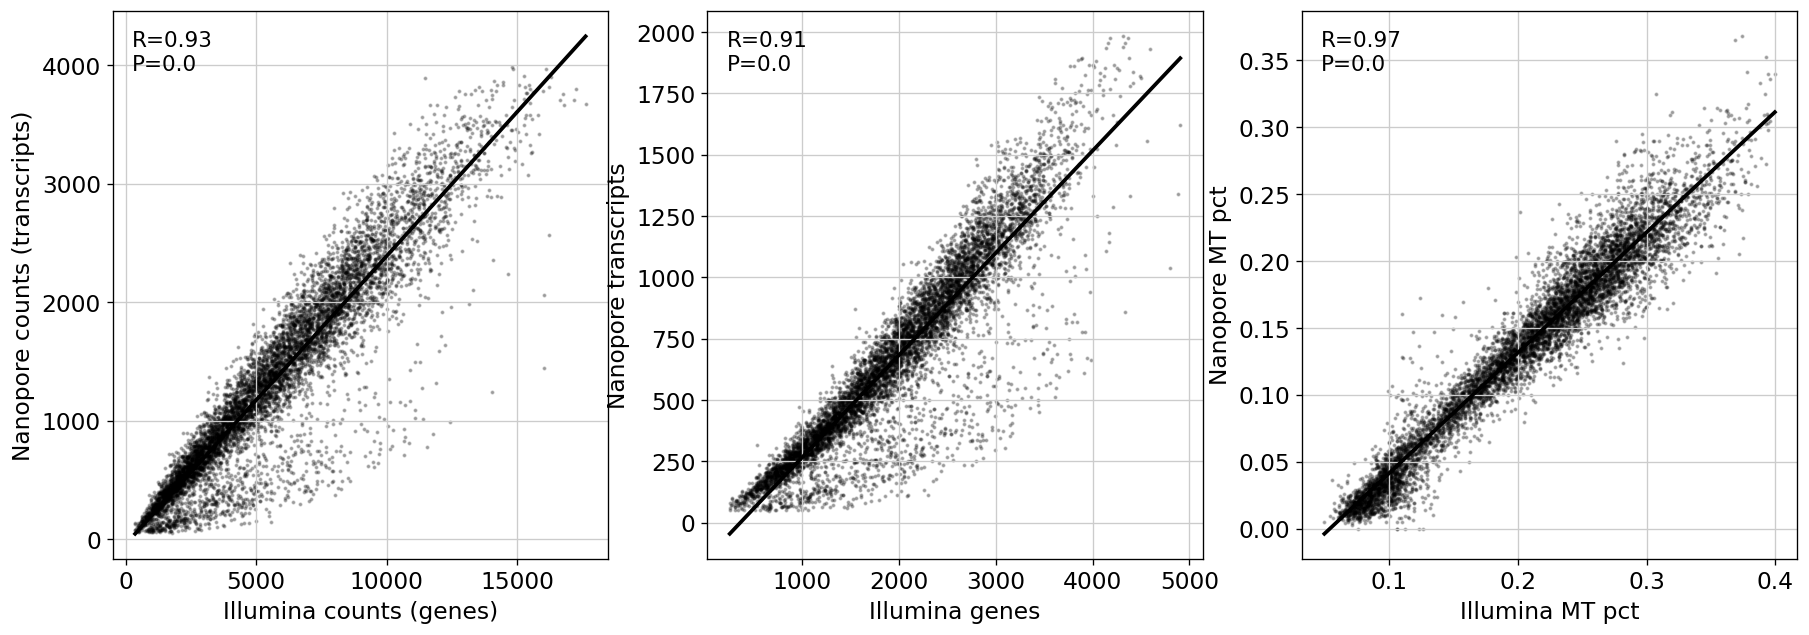

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

slope, intercept, r_value, pv, se = stats.linregress(obs['Illumina counts (genes)'], obs['Nanopore counts (transcripts)'])
sns.regplot(x="Illumina counts (genes)", y="Nanopore counts (transcripts)", data=obs, ax=ax1,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2, 'alpha':0.25}).legend(loc="best", frameon=False)

leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
slope, intercept, r_value, pv, se = stats.linregress(obs['Illumina genes'], obs['Nanopore transcripts'])
sns.regplot(x="Illumina genes", y="Nanopore transcripts", data=obs, ax=ax2,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2, 'alpha':0.25}).legend(loc="best", frameon=False)

leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
slope, intercept, r_value, pv, se = stats.linregress(obs['Illumina MT pct'], obs['Nanopore MT pct'])
sns.regplot(x="Illumina MT pct", y="Nanopore MT pct", data=obs, ax=ax3,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2, 'alpha':0.25}).legend(loc="best", frameon=False)

leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', 'S1', f"panel2.pdf")
fig.savefig(filen, bbox_inches = "tight")
filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', 'S1', f"panel2.svg")
fig.savefig(filen, bbox_inches = "tight")